In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
import pathlib
data_dir = r'D:\Personal Data\Data Science\Personal Project\Final Project Purwadhika - JKT Foodies One Stop Guide\5 - IMAGE CLASSIFIER\Zomato - Cuisine Type'
data_dir = pathlib.Path(data_dir)

In [3]:
category = ['Ayam', 'Bakmi', 'Bakso', 'Desserts', 'Kopi', 'Kue & Roti', 'Seafood', 'Snacks', 'Soto', 'Tea']

In [9]:
img_cat_count = []

for cat in category:
    img_count = len(list(data_dir.glob('{}/*.jpg'.format(cat))))
    print(f"Total Images for Category {cat}:", img_count)
    img_cat_count.append(img_count)

total_img = len(list(data_dir.glob('*/*.jpg')))
print(f"Total Training Images for All Category: {total_img}")

Total Images for Category Ayam: 1505
Total Images for Category Bakmi: 1474
Total Images for Category Bakso: 1554
Total Images for Category Desserts: 1523
Total Images for Category Kopi: 1495
Total Images for Category Kue & Roti: 1478
Total Images for Category Seafood: 1496
Total Images for Category Snacks: 1512
Total Images for Category Soto: 1485
Total Images for Category Tea: 1444
Total Training Images for All Category: 14966


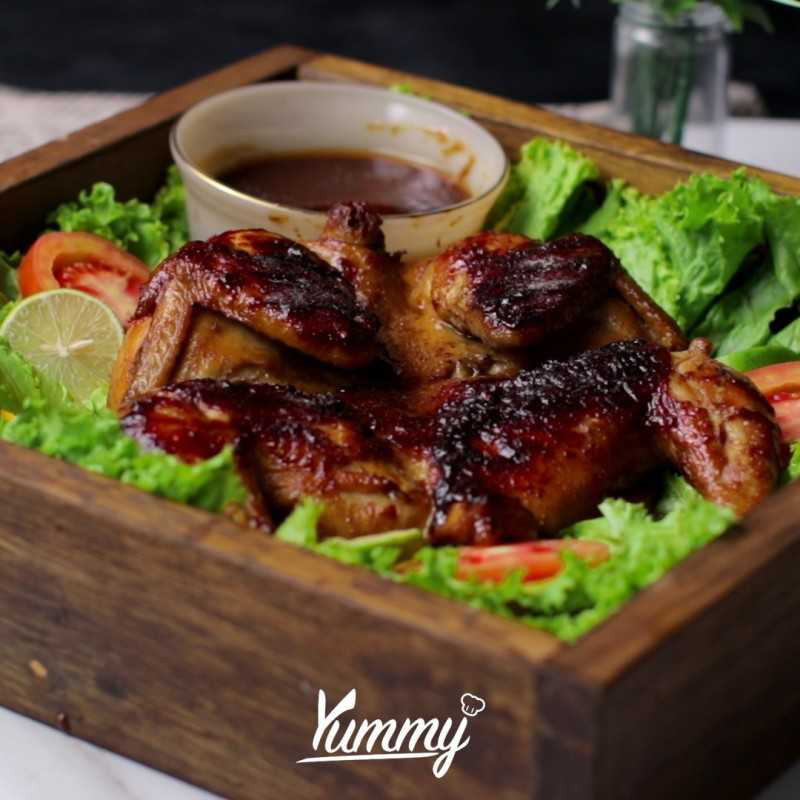

In [125]:
ayam = list(data_dir.glob('Ayam/*'))
PIL.Image.open(str(ayam[0]))

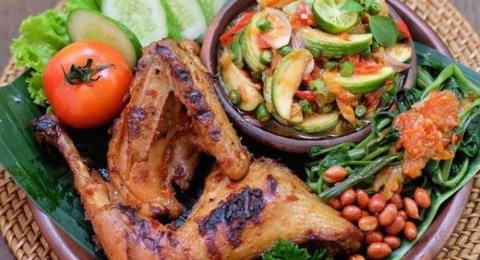

In [126]:
PIL.Image.open(str(ayam[1]))

In [10]:
batch_size = 32
img_height = 160
img_width = 160

IMG_SIZE = (img_height, img_width)

In [11]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.25) # set validation split

In [12]:
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed = 123,
    subset='training') # set as training data

val_ds = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed = 123,
    subset='validation') # set as validation data

Found 12014 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32, 10)


# STEP 1

## Train Last 5 Layers
## Fine Tune Bottom Layers

In [64]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(10, activation='softmax')(x)
 
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [65]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_ds, epochs=5 ,validation_data = val_ds, verbose = 1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/5
376/376 [==============================] - 879s 2s/step - loss: 2.3754 - accuracy: 0.4165 - val_loss: 1.4788 - val_accuracy: 0.4780
Epoch 2/5
376/376 [==============================] - 905s 2s/step - loss: 1.3383 - accuracy: 0.5170 - val_loss: 1.4060 - val_accuracy: 0.5178
Epoch 3/5
376/376 [==============================] - 848s 2s/step - loss: 1.2532 - accuracy: 0.5524 - val_loss: 1.2981 - val_accuracy: 0.5673
Epoch 4/5
376/376 [==============================] - 825s 2s/step - loss: 1.2000 - accuracy: 0.5773 - val_loss: 1.4703 - val_accuracy: 0.5010
Epoch 5/5
376/376 [==============================] - 852s 2s/step - loss: 1.1805 - accuracy: 0.5787 - val_loss: 1.1977 - val_accuracy: 0.5763


In [66]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_9
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

In [68]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.summary()
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])



Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [67]:
model.save("ZomateTF01.h5")

In [69]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_ds, epochs=10, validation_data = val_ds, verbose = 1)

Epoch 1/10
376/376 [==============================] - 911s 2s/step - loss: 1.5048 - accuracy: 0.5097 - val_loss: 1.3799 - val_accuracy: 0.5443
Epoch 2/10
376/376 [==============================] - 908s 2s/step - loss: 1.3037 - accuracy: 0.5601 - val_loss: 1.2680 - val_accuracy: 0.5658
Epoch 3/10
376/376 [==============================] - 896s 2s/step - loss: 1.2094 - accuracy: 0.5791 - val_loss: 1.2062 - val_accuracy: 0.5717
Epoch 4/10
376/376 [==============================] - 889s 2s/step - loss: 1.1630 - accuracy: 0.5915 - val_loss: 1.1810 - val_accuracy: 0.5945
Epoch 5/10
376/376 [==============================] - 904s 2s/step - loss: 1.1078 - accuracy: 0.6130 - val_loss: 1.1425 - val_accuracy: 0.6035
Epoch 6/10
376/376 [==============================] - 932s 2s/step - loss: 1.0790 - accuracy: 0.6229 - val_loss: 1.1168 - val_accuracy: 0.6090
Epoch 7/10
376/376 [==============================] - 955s 3s/step - loss: 1.0513 - accuracy: 0.6302 - val_loss: 1.1150 - val_accuracy: 0.6110

In [70]:
model.save("ZomateTF02.h5")

# STEP 2

In [71]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:200]:
   layer.trainable = False
for layer in model.layers[200:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.summary()
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [72]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_ds, epochs=10, validation_data = val_ds, verbose = 1)

Epoch 1/10
376/376 [==============================] - 935s 2s/step - loss: 1.0823 - accuracy: 0.6107 - val_loss: 1.0995 - val_accuracy: 0.6150
Epoch 2/10
376/376 [==============================] - 936s 2s/step - loss: 1.0378 - accuracy: 0.6376 - val_loss: 1.0739 - val_accuracy: 0.6217
Epoch 3/10
376/376 [==============================] - 954s 3s/step - loss: 0.9962 - accuracy: 0.6488 - val_loss: 1.0530 - val_accuracy: 0.6420
Epoch 4/10
376/376 [==============================] - 947s 3s/step - loss: 0.9669 - accuracy: 0.6552 - val_loss: 1.0095 - val_accuracy: 0.6515
Epoch 5/10
376/376 [==============================] - 967s 3s/step - loss: 0.9481 - accuracy: 0.6684 - val_loss: 0.9953 - val_accuracy: 0.6497
Epoch 6/10
376/376 [==============================] - 1009s 3s/step - loss: 0.9226 - accuracy: 0.6757 - val_loss: 0.9837 - val_accuracy: 0.6503
Epoch 7/10
376/376 [==============================] - 936s 2s/step - loss: 0.9112 - accuracy: 0.6825 - val_loss: 0.9630 - val_accuracy: 0.664

In [77]:
model.save("ZomateTF03.h5")

# STEP 3

In [78]:
for layer in model.layers[:150]:
   layer.trainable = False
for layer in model.layers[150:]:
   layer.trainable = True

model.summary()
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [13]:
epoch = 30
history = model.fit(train_ds, epochs=60, validation_data = val_ds, verbose = 1, initial_epoch=epoch)

Epoch 31/60
376/376 [==============================] - 925s 2s/step - loss: 0.8361 - accuracy: 0.7044 - val_loss: 0.9430 - val_accuracy: 0.6812
Epoch 32/60
376/376 [==============================] - 874s 2s/step - loss: 0.8176 - accuracy: 0.7143 - val_loss: 0.9205 - val_accuracy: 0.6927
Epoch 33/60
376/376 [==============================] - 855s 2s/step - loss: 0.8048 - accuracy: 0.7128 - val_loss: 0.9122 - val_accuracy: 0.6870
Epoch 34/60
376/376 [==============================] - 824s 2s/step - loss: 0.7879 - accuracy: 0.7213 - val_loss: 0.8848 - val_accuracy: 0.6995
Epoch 35/60
376/376 [==============================] - 767s 2s/step - loss: 0.7868 - accuracy: 0.7247 - val_loss: 0.8732 - val_accuracy: 0.6955
Epoch 36/60
376/376 [==============================] - 752s 2s/step - loss: 0.7575 - accuracy: 0.7346 - val_loss: 0.8880 - val_accuracy: 0.6952
Epoch 37/60
376/376 [==============================] - 752s 2s/step - loss: 0.7615 - accuracy: 0.7296 - val_loss: 0.8672 - val_accuracy:

In [15]:
model.save("ZomateTF04.h5")

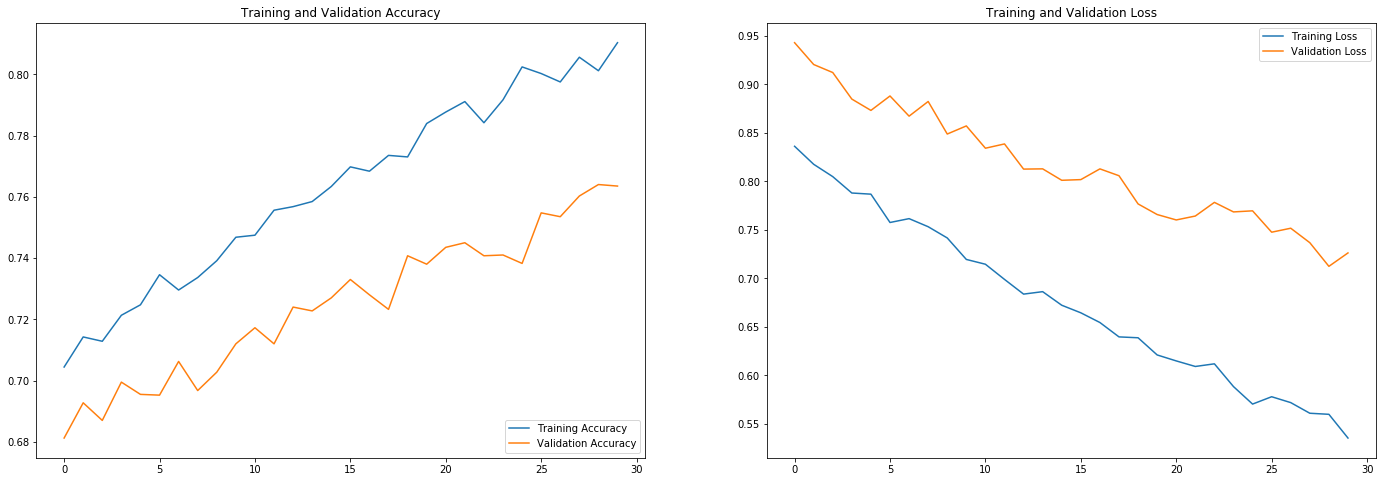

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
from tensorflow import keras

model = keras.models.load_model('ZomateTF04.h5')
model.summary()

lossx, accx = model.evaluate(train_ds,steps=10)
print("Restored model, accuracy against Training Data: {:5.2f}%".format(100*accx))

lossx, accx = model.evaluate(val_ds,steps=10)
print("Restored model, accuracy against Validation Data: {:5.2f}%".format(100*accx))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [24]:
record = pd.DataFrame({'Train Accuracy': acc, 'Validation Accuracy': val_acc, 'Train Loss': loss, 'Validation Loss': val_loss}, index=range(31,61))

In [26]:
record.to_excel("Cuisine Image Classifer Progress Record.xlsx", index=False)
record.to_csv("Cuisine Image Classifer Progress Record.csv", index=False)

# STEP 4

In [28]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.35) # set validation split

In [29]:
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed = 123,
    subset='training') # set as training data

val_ds = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed = 123,
    subset='validation') # set as validation data

Found 11214 images belonging to 10 classes.
Found 4800 images belonging to 10 classes.


In [30]:
for layer in model.layers[:125]:
   layer.trainable = False
for layer in model.layers[125:]:
   layer.trainable = True

model.summary()
model.compile(optimizer=SGD(lr=0.00005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

NameError: name 'SGD' is not defined

In [31]:
epoch = 60
history_step2 = model.fit(train_ds, epochs=90, validation_data = val_ds, verbose = 1, initial_epoch=epoch)

Epoch 61/90
351/351 [==============================] - 979s 3s/step - loss: 0.5385 - accuracy: 0.8090 - val_loss: 0.6747 - val_accuracy: 0.7837
Epoch 62/90
351/351 [==============================] - 867s 2s/step - loss: 0.5282 - accuracy: 0.8152 - val_loss: 0.6631 - val_accuracy: 0.7740
Epoch 63/90
351/351 [==============================] - 838s 2s/step - loss: 0.5119 - accuracy: 0.8210 - val_loss: 0.6479 - val_accuracy: 0.7856
Epoch 64/90
351/351 [==============================] - 796s 2s/step - loss: 0.4999 - accuracy: 0.8248 - val_loss: 0.6649 - val_accuracy: 0.7773
Epoch 65/90
351/351 [==============================] - 758s 2s/step - loss: 0.5222 - accuracy: 0.8167 - val_loss: 0.6766 - val_accuracy: 0.7740
Epoch 66/90
351/351 [==============================] - 758s 2s/step - loss: 0.5056 - accuracy: 0.8233 - val_loss: 0.6674 - val_accuracy: 0.7848
Epoch 67/90
351/351 [==============================] - 756s 2s/step - loss: 0.4991 - accuracy: 0.8289 - val_loss: 0.6560 - val_accuracy:

In [61]:
model.save("ZomateTF05.h5")

In [38]:
acc_prev = acc
val_acc_prev = val_acc
loss_prev = loss
val_loss_prev = val_loss

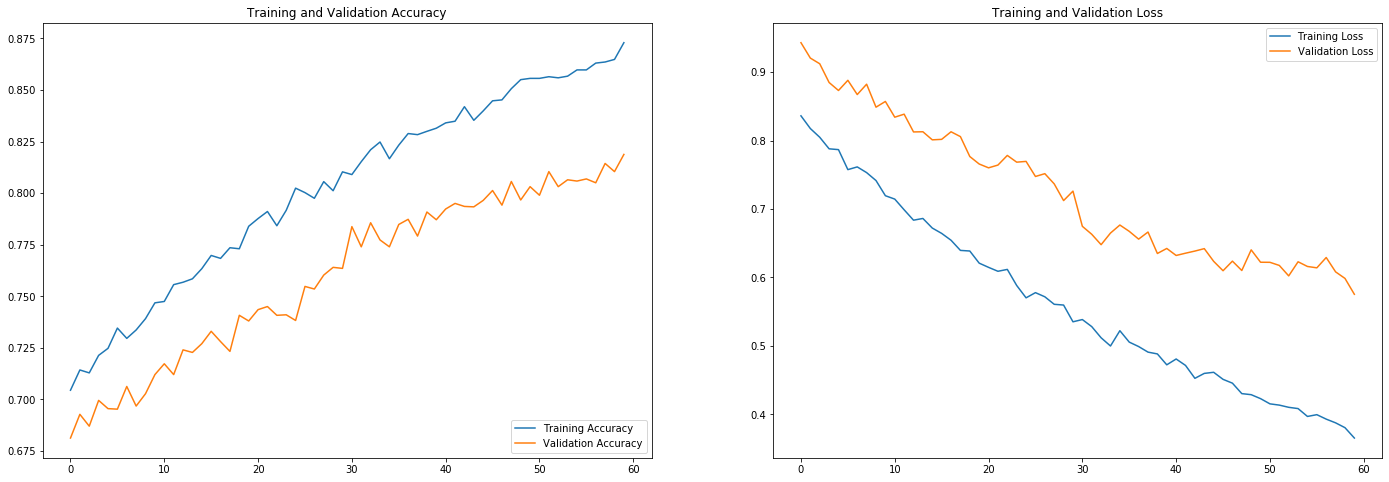

In [43]:
acc = history_step2.history['accuracy']
val_acc = history_step2.history['val_accuracy']

loss = history_step2.history['loss']
val_loss = history_step2.history['val_loss']

acc = acc_prev + acc
val_acc = val_acc_prev + val_acc
loss = loss_prev + loss
val_loss = val_loss_prev + val_loss

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
record = pd.DataFrame({'Train Accuracy': acc, 'Validation Accuracy': val_acc, 'Train Loss': loss, 'Validation Loss': val_loss}, index=range(31,91))

In [46]:
record.to_excel("Cuisine Image Classifer Progress Record.xlsx", index=False)
record.to_csv("Cuisine Image Classifer Progress Record.csv", index=False)

In [10]:
from tensorflow import keras

model = keras.models.load_model('ZomateTF05.h5')
model.summary()

lossx, accx = model.evaluate(train_ds,steps=20)
print("Restored model, accuracy against Training Data: {:5.2f}%".format(100*accx))

lossx, accx = model.evaluate(val_ds,steps=20)
print("Restored model, accuracy against Validation Data: {:5.2f}%".format(100*accx))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

# STEP 4 REVISED

In [11]:
for layer in model.layers[:140]:
   layer.trainable = False
for layer in model.layers[140:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.summary()
model.compile(optimizer=SGD(lr=0.00005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [12]:
epoch = 90
history_step3 = model.fit(train_ds, epochs=100, validation_data = val_ds, verbose = 1, initial_epoch=epoch)

Epoch 91/100
376/376 [==============================] - 943s 3s/step - loss: 0.6241 - accuracy: 0.7794 - val_loss: 0.8085 - val_accuracy: 0.7358
Epoch 92/100
376/376 [==============================] - 953s 3s/step - loss: 0.5774 - accuracy: 0.7976 - val_loss: 0.8167 - val_accuracy: 0.7473
Epoch 93/100
376/376 [==============================] - 945s 3s/step - loss: 0.5531 - accuracy: 0.8006 - val_loss: 0.7586 - val_accuracy: 0.7613
Epoch 94/100
376/376 [==============================] - 1001s 3s/step - loss: 0.5224 - accuracy: 0.8157 - val_loss: 0.7731 - val_accuracy: 0.7517
Epoch 95/100
376/376 [==============================] - 973s 3s/step - loss: 0.5189 - accuracy: 0.8149 - val_loss: 0.7150 - val_accuracy: 0.7717
Epoch 96/100
376/376 [==============================] - 996s 3s/step - loss: 0.5043 - accuracy: 0.8253 - val_loss: 0.7068 - val_accuracy: 0.7730
Epoch 97/100
376/376 [==============================] - 980s 3s/step - loss: 0.4879 - accuracy: 0.8258 - val_loss: 0.7049 - val_a

In [13]:
model.save("ZomateTF05-B.h5")

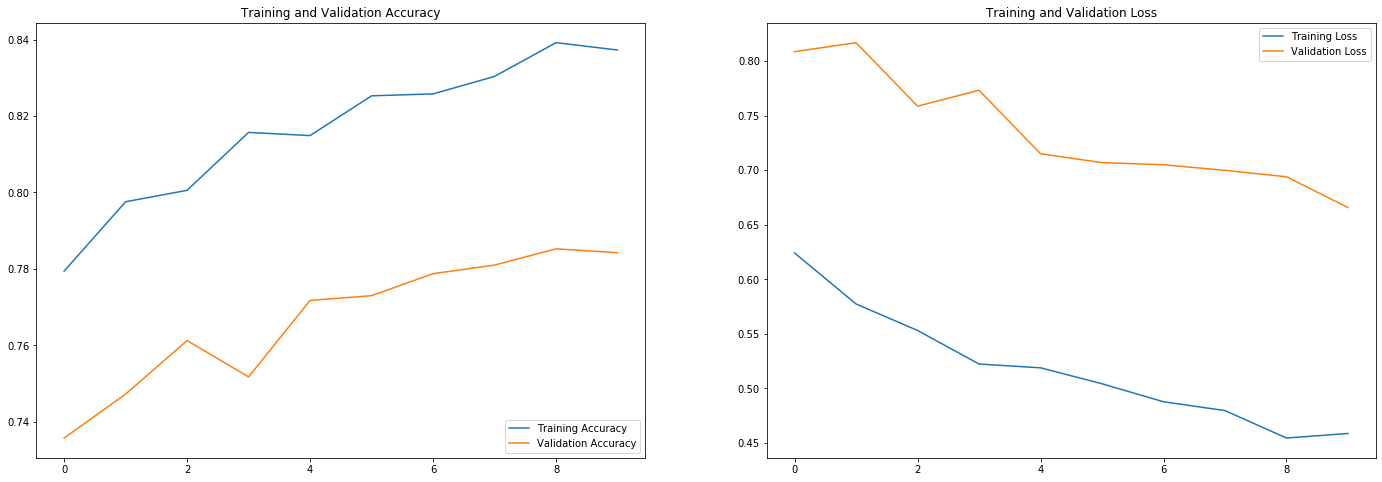

In [16]:
acc = history_step3.history['accuracy']
val_acc = history_step3.history['val_accuracy']

loss = history_step3.history['loss']
val_loss = history_step3.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
record = pd.DataFrame({'Train Accuracy': acc, 'Validation Accuracy': val_acc, 'Train Loss': loss, 'Validation Loss': val_loss}, index=range(61,71))

In [19]:
record.to_excel("Cuisine Image Classifer Progress Record 61-70.xlsx", index=False)
record.to_csv("Cuisine Image Classifer Progress Record 61-70.csv", index=False)

In [20]:
from tensorflow import keras

model = keras.models.load_model('ZomateTF05-B.h5')
model.summary()

lossx, accx = model.evaluate(train_ds,steps=20)
print("Restored model, accuracy against Training Data: {:5.2f}%".format(100*accx))

lossx, accx = model.evaluate(val_ds,steps=20)
print("Restored model, accuracy against Validation Data: {:5.2f}%".format(100*accx))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

# STEP 5

In [22]:
for layer in model.layers[:135]:
   layer.trainable = False
for layer in model.layers[135:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.summary()
model.compile(optimizer=SGD(lr=0.00005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [23]:
epoch = 70
history_step3B = model.fit(train_ds, epochs=95, validation_data = val_ds, verbose = 1, initial_epoch=epoch)

Epoch 71/95
376/376 [==============================] - 952s 3s/step - loss: 0.4400 - accuracy: 0.8420 - val_loss: 0.6911 - val_accuracy: 0.7768
Epoch 72/95
376/376 [==============================] - 846s 2s/step - loss: 0.4327 - accuracy: 0.8469 - val_loss: 0.6750 - val_accuracy: 0.7853
Epoch 73/95
376/376 [==============================] - 839s 2s/step - loss: 0.4311 - accuracy: 0.8488 - val_loss: 0.6880 - val_accuracy: 0.7860
Epoch 74/95
376/376 [==============================] - 833s 2s/step - loss: 0.4312 - accuracy: 0.8503 - val_loss: 0.6673 - val_accuracy: 0.7853
Epoch 75/95
376/376 [==============================] - 833s 2s/step - loss: 0.4217 - accuracy: 0.8528 - val_loss: 0.6538 - val_accuracy: 0.7890
Epoch 76/95
376/376 [==============================] - 836s 2s/step - loss: 0.3958 - accuracy: 0.8607 - val_loss: 0.6527 - val_accuracy: 0.7880
Epoch 77/95
376/376 [==============================] - 828s 2s/step - loss: 0.3924 - accuracy: 0.8647 - val_loss: 0.6873 - val_accuracy:

In [24]:
model.save("ZomateTF06.h5")

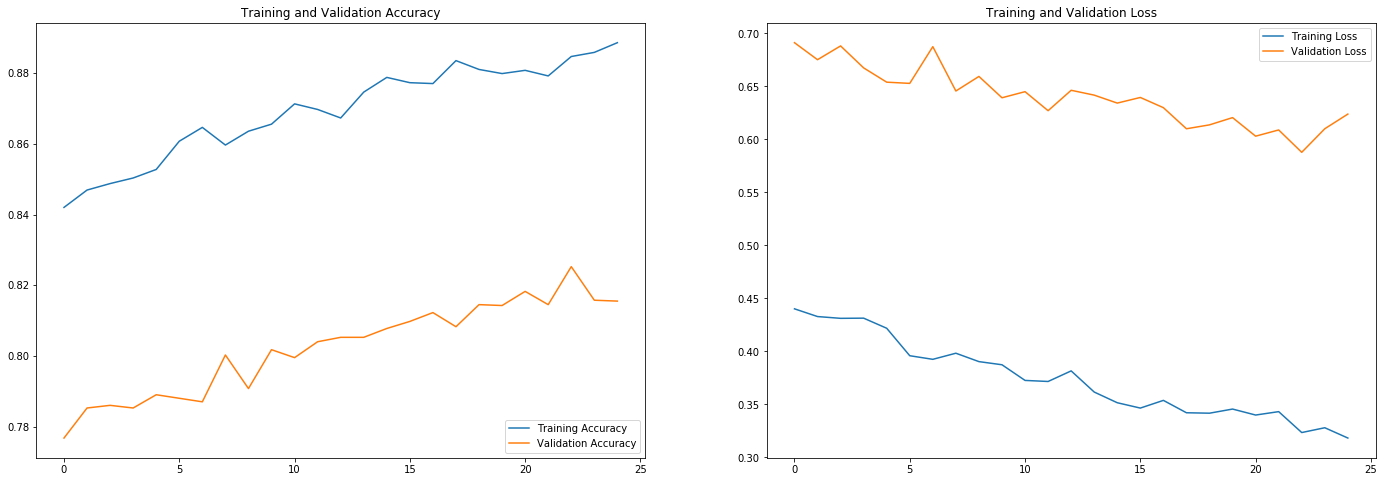

In [25]:
acc = history_step3B.history['accuracy']
val_acc = history_step3B.history['val_accuracy']

loss = history_step3B.history['loss']
val_loss = history_step3B.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
record = pd.DataFrame({'Train Accuracy': acc, 'Validation Accuracy': val_acc, 'Train Loss': loss, 'Validation Loss': val_loss})

In [28]:
record.to_excel("Cuisine Image Classifer Progress Record 71-95.xlsx", index=False)
record.to_csv("Cuisine Image Classifer Progress Record 71-95.csv", index=False)

In [29]:
from tensorflow import keras

model = keras.models.load_model('ZomateTF06.h5')
model.summary()

lossx, accx = model.evaluate(train_ds,steps=20)
print("Restored model, accuracy against Training Data: {:5.2f}%".format(100*accx))

lossx, accx = model.evaluate(val_ds,steps=20)
print("Restored model, accuracy against Validation Data: {:5.2f}%".format(100*accx))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

# STEP 6

In [30]:
for layer in model.layers[:120]:
   layer.trainable = False
for layer in model.layers[120:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.summary()
model.compile(optimizer=SGD(lr=0.00005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [31]:
epoch = 95
history_step4 = model.fit(train_ds, epochs=115, validation_data = val_ds, verbose = 1, initial_epoch=epoch)

Epoch 96/115
376/376 [==============================] - 1434s 4s/step - loss: 0.3486 - accuracy: 0.8805 - val_loss: 0.6065 - val_accuracy: 0.8125
Epoch 97/115
376/376 [==============================] - 1682s 4s/step - loss: 0.3380 - accuracy: 0.8811 - val_loss: 0.6360 - val_accuracy: 0.8120
Epoch 98/115
376/376 [==============================] - 951s 3s/step - loss: 0.3320 - accuracy: 0.8859 - val_loss: 0.6211 - val_accuracy: 0.8180
Epoch 99/115
376/376 [==============================] - 875s 2s/step - loss: 0.3232 - accuracy: 0.8866 - val_loss: 0.6129 - val_accuracy: 0.8163
Epoch 100/115
376/376 [==============================] - 901s 2s/step - loss: 0.3293 - accuracy: 0.8844 - val_loss: 0.6057 - val_accuracy: 0.8170
Epoch 101/115
376/376 [==============================] - 964s 3s/step - loss: 0.3270 - accuracy: 0.8865 - val_loss: 0.6156 - val_accuracy: 0.8230
Epoch 102/115
376/376 [==============================] - 933s 2s/step - loss: 0.3194 - accuracy: 0.8902 - val_loss: 0.6087 - v

In [32]:
model.save("ZomateTF07.h5")

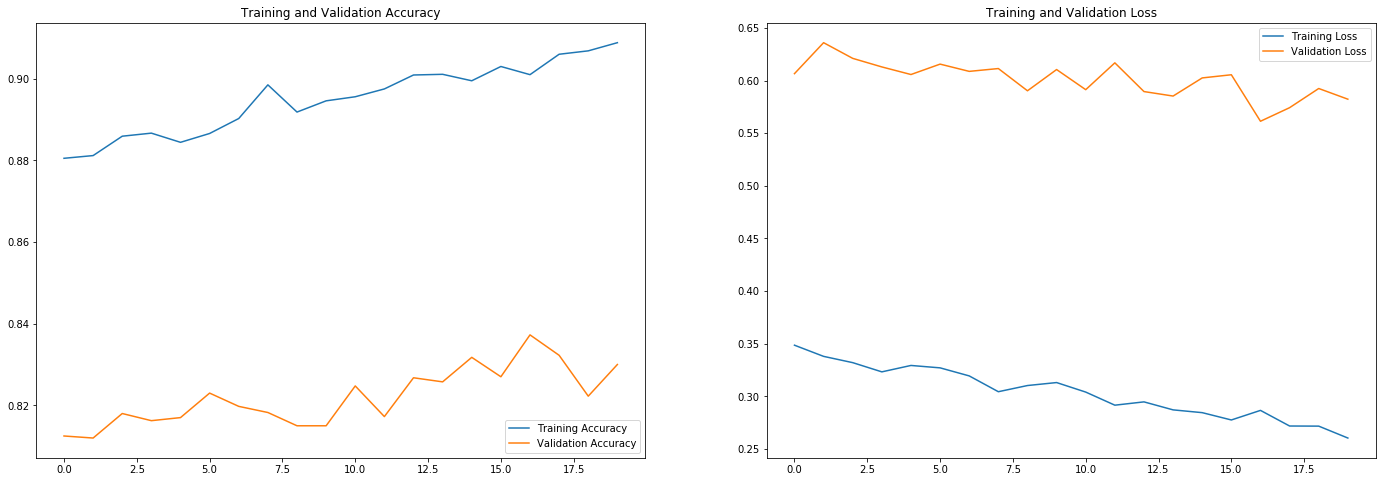

In [33]:
acc = history_step4.history['accuracy']
val_acc = history_step4.history['val_accuracy']

loss = history_step4.history['loss']
val_loss = history_step4.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
record = pd.DataFrame({'Train Accuracy': acc, 'Validation Accuracy': val_acc, 'Train Loss': loss, 'Validation Loss': val_loss})

In [35]:
record.to_excel("Cuisine Image Classifer Progress Record 96-115.xlsx", index=False)
record.to_csv("Cuisine Image Classifer Progress Record 96-115.csv", index=False)

In [13]:
from tensorflow import keras

model = keras.models.load_model('ZomateTF07.h5')
model.summary()

lossx, accx = model.evaluate(train_ds,steps=20)
print("Restored model, accuracy against Training Data: {:5.2f}%".format(100*accx))

lossx, accx = model.evaluate(val_ds,steps=20)
print("Restored model, accuracy against Validation Data: {:5.2f}%".format(100*accx))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

# STEP 7

In [14]:
for layer in model.layers[:105]:
   layer.trainable = False
for layer in model.layers[105:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.summary()
model.compile(optimizer=SGD(lr=0.00005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [15]:
epoch = 115
history_step5 = model.fit(train_ds, epochs=145, validation_data = val_ds, verbose = 1, initial_epoch=epoch)

Epoch 116/145
376/376 [==============================] - 1058s 3s/step - loss: 0.2808 - accuracy: 0.9031 - val_loss: 0.6024 - val_accuracy: 0.8322
Epoch 117/145
376/376 [==============================] - 997s 3s/step - loss: 0.2815 - accuracy: 0.9046 - val_loss: 0.6072 - val_accuracy: 0.8305
Epoch 118/145
376/376 [==============================] - 929s 2s/step - loss: 0.2660 - accuracy: 0.9059 - val_loss: 0.5721 - val_accuracy: 0.8320
Epoch 119/145
376/376 [==============================] - 935s 2s/step - loss: 0.2764 - accuracy: 0.9015 - val_loss: 0.6051 - val_accuracy: 0.8238
Epoch 120/145
376/376 [==============================] - 899s 2s/step - loss: 0.2760 - accuracy: 0.9054 - val_loss: 0.5722 - val_accuracy: 0.8350
Epoch 121/145
376/376 [==============================] - 872s 2s/step - loss: 0.2597 - accuracy: 0.9124 - val_loss: 0.5594 - val_accuracy: 0.8367
Epoch 122/145
376/376 [==============================] - 968s 3s/step - loss: 0.2541 - accuracy: 0.9116 - val_loss: 0.5832 

In [16]:
model.save("ZomateTF08.h5")

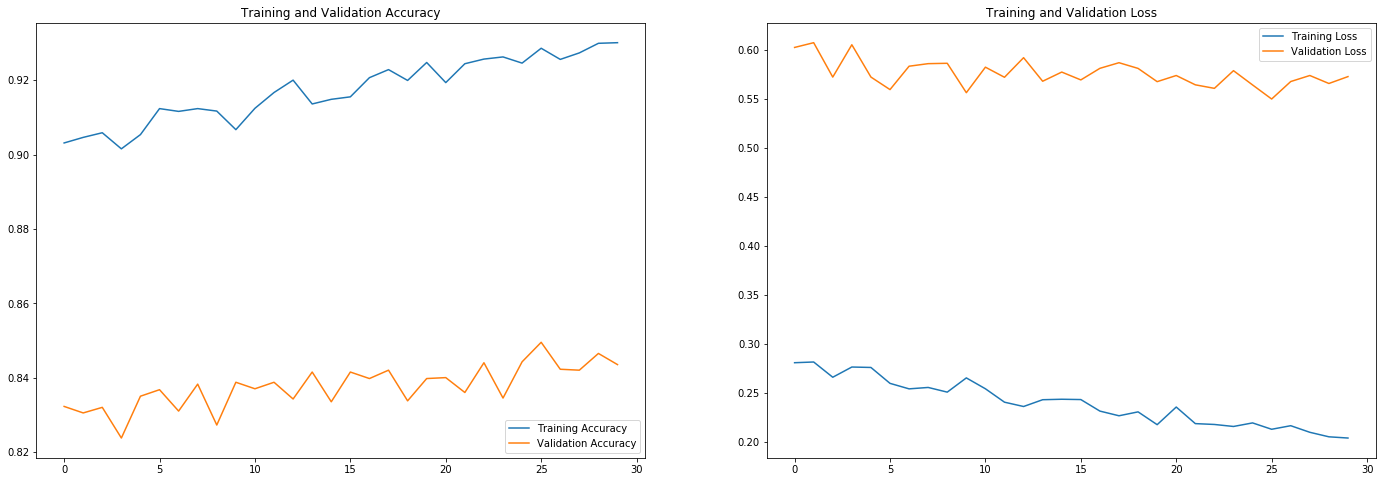

In [17]:
acc = history_step5.history['accuracy']
val_acc = history_step5.history['val_accuracy']

loss = history_step5.history['loss']
val_loss = history_step5.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
record = pd.DataFrame({'Train Accuracy': acc, 'Validation Accuracy': val_acc, 'Train Loss': loss, 'Validation Loss': val_loss})

In [19]:
record.to_excel("Cuisine Image Classifer Progress Record 116-145.xlsx", index=False)
record.to_csv("Cuisine Image Classifer Progress Record 116-145.csv", index=False)

In [20]:
from tensorflow import keras

model = keras.models.load_model('ZomateTF08.h5')
model.summary()

lossx, accx = model.evaluate(train_ds,steps=20)
print("Restored model, accuracy against Training Data: {:5.2f}%".format(100*accx))

lossx, accx = model.evaluate(val_ds,steps=20)
print("Restored model, accuracy against Validation Data: {:5.2f}%".format(100*accx))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

# STEP 8

In [21]:
for layer in model.layers[:90]:
   layer.trainable = False
for layer in model.layers[90:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.summary()
model.compile(optimizer=SGD(lr=0.00005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [22]:
epoch = 145
history_step6 = model.fit(train_ds, epochs=185, validation_data = val_ds, verbose = 1, initial_epoch=epoch)

Epoch 146/185
376/376 [==============================] - 1051s 3s/step - loss: 0.2231 - accuracy: 0.9236 - val_loss: 0.5586 - val_accuracy: 0.8425
Epoch 147/185
376/376 [==============================] - 1531s 4s/step - loss: 0.2160 - accuracy: 0.9261 - val_loss: 0.5632 - val_accuracy: 0.8418
Epoch 148/185
376/376 [==============================] - 1013s 3s/step - loss: 0.2068 - accuracy: 0.9296 - val_loss: 0.5478 - val_accuracy: 0.8522
Epoch 149/185
376/376 [==============================] - 992s 3s/step - loss: 0.2159 - accuracy: 0.9208 - val_loss: 0.5578 - val_accuracy: 0.8445
Epoch 150/185
376/376 [==============================] - 947s 3s/step - loss: 0.2120 - accuracy: 0.9271 - val_loss: 0.5827 - val_accuracy: 0.8455
Epoch 151/185
376/376 [==============================] - 940s 3s/step - loss: 0.2056 - accuracy: 0.9277 - val_loss: 0.5593 - val_accuracy: 0.8440
Epoch 152/185
376/376 [==============================] - 957s 3s/step - loss: 0.1948 - accuracy: 0.9328 - val_loss: 0.553

In [23]:
model.save("ZomateTF09.h5")

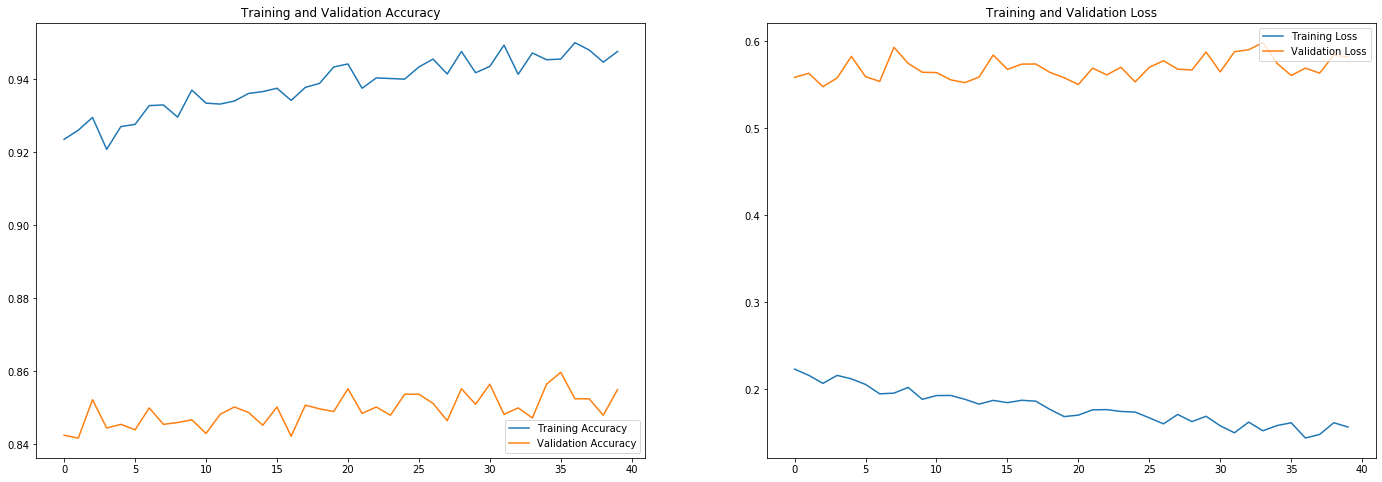

In [24]:
acc = history_step6.history['accuracy']
val_acc = history_step6.history['val_accuracy']

loss = history_step6.history['loss']
val_loss = history_step6.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
record = pd.DataFrame({'Train Accuracy': acc, 'Validation Accuracy': val_acc, 'Train Loss': loss, 'Validation Loss': val_loss})
record.to_excel("Cuisine Image Classifer Progress Record 146-185.xlsx", index=False)
record.to_csv("Cuisine Image Classifer Progress Record 146-185.csv", index=False)

In [26]:
from tensorflow import keras

model = keras.models.load_model('ZomateTF09.h5')
model.summary()

lossx, accx = model.evaluate(train_ds,steps=20)
print("Restored model, accuracy against Training Data: {:5.2f}%".format(100*accx))

lossx, accx = model.evaluate(val_ds,steps=20)
print("Restored model, accuracy against Validation Data: {:5.2f}%".format(100*accx))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

# FINAL GRAPH

In [8]:
tograph_0 = pd.read_excel("Cuisine Image Classifer Progress Record Top Layers 1-5.xlsx")

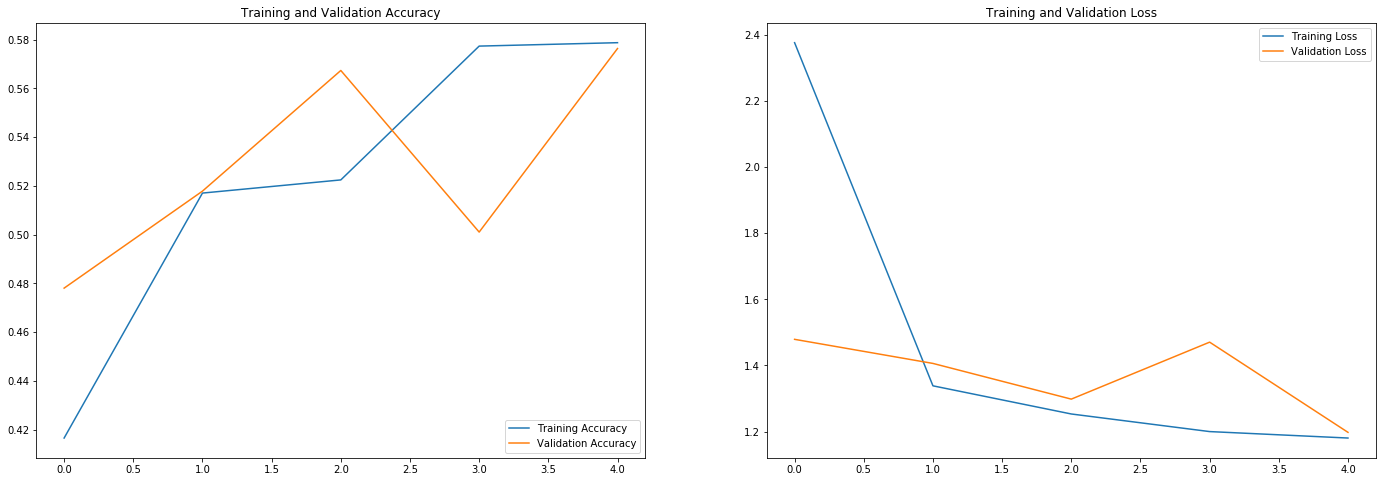

In [9]:
acc = tograph_0['Train Accuracy']
val_acc = tograph_0['Validation Accuracy']

loss = tograph_0['Train Loss']
val_loss = tograph_0['Validation Loss']

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [5]:
tograph = pd.read_excel('Cuisine Image Classifer Progress Record 1-175.xlsx')

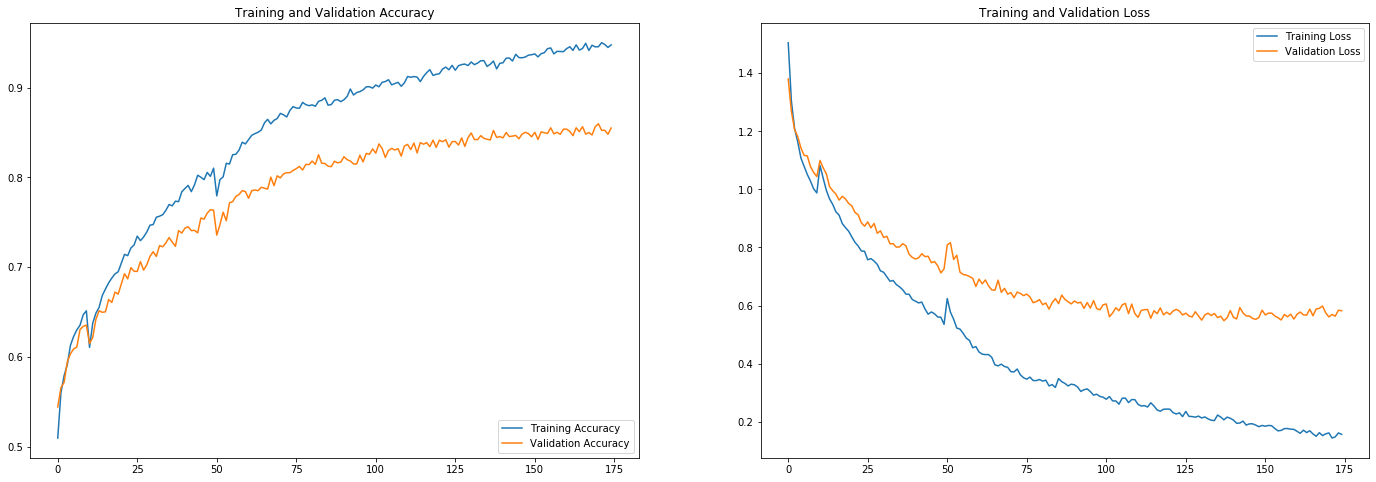

In [7]:
acc = tograph['Train Accuracy']
val_acc = tograph['Validation Accuracy']

loss = tograph['Train Loss']
val_loss = tograph['Validation Loss']

epochs_range = range(len(acc))

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# TEST PREDICTION FOR DEPLOYMENT

In [45]:
import pathlib
deploy_dir = r'D:\Personal Data\Data Science\Personal Project\Zomato Jakarta Scraping\5 - IMAGE CLASSIFIER\Zomato - Cuisine Type for Test'
deploy_dir = pathlib.Path(deploy_dir)

In [46]:
from keras_preprocessing.image import ImageDataGenerator

deploy_datagen = ImageDataGenerator(rescale=1./255)

In [54]:
deploy_ds = deploy_datagen.flow_from_directory(
    deploy_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    seed = 123)

Found 12 images belonging to 1 classes.


In [56]:
#Retrieve a batch of images from the test set
image_batch, label_batch = deploy_ds.next()

In [57]:
image_batch.shape

(1, 160, 160, 3)

In [49]:
predictions = model.predict_on_batch(image_batch)

In [36]:
predictions.shape

(12, 10)

In [50]:
pred_class_indices = np.argmax(predictions, axis=1)

In [51]:
print(pred_class_indices)

[0 0 0 0 0 0 0 0 6 0 0 0]


In [42]:
labels = (train_ds.class_indices)
labels

{'Ayam': 0,
 'Bakmi': 1,
 'Bakso': 2,
 'Desserts': 3,
 'Kopi': 4,
 'Kue & Roti': 5,
 'Seafood': 6,
 'Snacks': 7,
 'Soto': 8,
 'Tea': 9}

In [43]:
labels_reverse = dict((v,k) for k,v in labels.items())
predictions = [labels_reverse[a] for a in pred_class_indices]
print(predictions)

['Ayam', 'Ayam', 'Ayam', 'Seafood', 'Ayam', 'Ayam', 'Ayam', 'Ayam', 'Seafood', 'Ayam', 'Ayam', 'Ayam']


In [52]:
category = {'Ayam': 0,
 'Bakmi': 1,
 'Bakso': 2,
 'Desserts': 3,
 'Kopi': 4,
 'Kue & Roti': 5,
 'Seafood': 6,
 'Snacks': 7,
 'Soto': 8,
 'Tea': 9}

In [53]:
category

{'Ayam': 0,
 'Bakmi': 1,
 'Bakso': 2,
 'Desserts': 3,
 'Kopi': 4,
 'Kue & Roti': 5,
 'Seafood': 6,
 'Snacks': 7,
 'Soto': 8,
 'Tea': 9}

In [58]:
predictions = model.predict(image_batch)

In [59]:
pred_class_indices = np.argmax(predictions, axis=1)

In [60]:
print(pred_class_indices)

[0]


In [62]:
labels_reverse = dict((v,k) for k,v in labels.items())
predictions = [labels_reverse[a] for a in pred_class_indices]
print(predictions[0])

Ayam


In [63]:
labels_reverse

{0: 'Ayam',
 1: 'Bakmi',
 2: 'Bakso',
 3: 'Desserts',
 4: 'Kopi',
 5: 'Kue & Roti',
 6: 'Seafood',
 7: 'Snacks',
 8: 'Soto',
 9: 'Tea'}

In [ ]:
# Modify 'test1.jpg' and 'test2.jpg' to the images you want to predict on

from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 320, 240

# load the model we saved
model = load_model('model.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img('test1.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print classes


In [64]:
img_path = r"D:\Personal Data\Data Science\Personal Project\Zomato Jakarta Scraping\5 - IMAGE CLASSIFIER\Zomato - Cuisine Type for Test\Ayam"

In [84]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(160, 160))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    # if show:
    #     plt.imshow(img_tensor[0])                           
    #     plt.axis('off')
    #     plt.show()

    return img_tensor

In [85]:
model = keras.models.load_model('ZomateTF07.h5')
img_path = r"D:\Personal Data\Data Science\Personal Project\Zomato Jakarta Scraping\5 - IMAGE CLASSIFIER\Zomato - Cuisine Type for Test\Ayam\ayambakar (2).jpg"
new_image = load_image(img_path)
pred = model.predict(new_image)

In [73]:
new_image.shape

(1, 160, 160, 3)

In [75]:
pred

array([[9.4857883e-01, 2.1689650e-06, 3.9994187e-04, 5.7563018e-05,
        1.7214823e-07, 2.3884229e-04, 1.7422326e-03, 4.8979130e-02,
        1.0085316e-06, 7.7973382e-08]], dtype=float32)

In [78]:
pred_class_indices = np.argmax(pred, axis=1)
labels_reverse = dict((v,k) for k,v in labels.items())
predictions = [labels_reverse[a] for a in pred_class_indices]
print(predictions[0])

Ayam


In [95]:
def classify(files):

    img = image.load_img(files, target_size=(160, 160))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)        
    img_tensor /= 255. 

    prediction = model.predict(img_tensor)
    pred_class_indices = np.argmax(prediction, axis=1)
    img_category = [category[a] for a in pred_class_indices]
    img_result = img_category[0]

    return img_result 

In [96]:
classify(r"D:\Personal Data\Data Science\Personal Project\Zomato Jakarta Scraping\5 - IMAGE CLASSIFIER\Zomato - Cuisine Type for Test\Ayam\ayambakar (2).jpg")

'Ayam'

In [91]:
files = r"D:\Personal Data\Data Science\Personal Project\Zomato Jakarta Scraping\5 - IMAGE CLASSIFIER\Zomato - Cuisine Type for Test\Ayam\ayambakar (2).jpg"

In [94]:
category = {0: 'Ayam', 1: 'Bakmi', 2: 'Bakso', 3: 'Desserts', 4: 'Kopi', 5: 'Kue & Roti', 6: 'Seafood', 7: 'Snacks', 8: 'Soto', 9: 'Tea'}

In [3]:
img = image.load_img(files, target_size=(160, 160))
img_tensor = image.img_to_array(img)                    
img_tensor = np.expand_dims(img_tensor, axis=0)        
img_tensor /= 255. 

prediction = model.predict(img_tensor)
pred_class_indices = np.argmax(prediction, axis=1)
img_category = [category[a] for a in pred_class_indices]
img_result = img_category[0]

In [93]:
pred_class_indices

array([0], dtype=int64)